In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.pyplot as plt

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
PATH = Path("../../data/")

In [6]:
scaler = joblib.load(PATH/'train_scaler_x.pkl')

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')

#dfX_Train = np.vstack((dfX_Train, dfX_Val))
#dfY_Train = np.vstack((dfY_Train, dfY_Val))

print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [8]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [9]:
#Normalize y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T

In [10]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


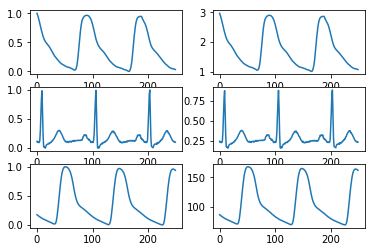

In [11]:
ax = plt.subplot(3,2,1)
ax.plot(valX_0_n[0,:])
ax = plt.subplot(3,2,2)
ax.plot(dfX_Val[0,ini:ini+dim])
ax = plt.subplot(3,2,3)
ax.plot(valX_1_n[0,:])
ax = plt.subplot(3,2,4)
ax.plot(dfX_Val[0,ini+ecg:ini+ecg+dim])
ax = plt.subplot(3,2,5)
ax.plot(valY_n[0,:])
ax = plt.subplot(3,2,6)
ax.plot(dfY_Val[0,ini:ini+dim])

plt.show()

In [12]:
#Definition of the model

In [39]:
model = Sequential()
model.add(Dense(dim*2, activation='relu', input_dim=dim*2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

#model.add(Dense(dim*2, activation='relu', input_dim=dim*2))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Dense(dim, activation='relu', input_dim=dim*2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(dim, activation='relu', input_dim=dim))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(dim))

model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_30 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_31 (Batc (None, 250)               1000      
_________________________________________________________________
dropout_31 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 250)               62750     
__________

In [41]:
print(np.hstack((trainX_0_n, trainX_1_n)).shape)
print(np.hstack((valX_0_n, valX_1_n)).shape)
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='mse')
history_prev = history
history = model.fit(np.hstack((trainX_0_n, trainX_1_n)), trainY_n, epochs=5, verbose=1, 
          validation_data=(np.hstack((valX_0_n, valX_1_n)),valY_n), batch_size=64)

(8126, 500)
(1016, 500)
Train on 8126 samples, validate on 1016 samples
Epoch 1/5
8126/8126 [==============================] - 3s 379us/step - loss: 0.0269 - val_loss: 0.0225
Epoch 2/5
8126/8126 [==============================] - 1s 122us/step - loss: 0.0262 - val_loss: 0.0223
Epoch 3/5
8126/8126 [==============================] - 1s 122us/step - loss: 0.0261 - val_loss: 0.0222
Epoch 4/5
8126/8126 [==============================] - 1s 122us/step - loss: 0.0257 - val_loss: 0.0221
Epoch 5/5
8126/8126 [==============================] - 1s 122us/step - loss: 0.0255 - val_loss: 0.0220


In [ ]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.set_ylim(0.0,1.0)
    ax.legend()

plt.show()

In [42]:
# Save the weights
model.save_weights('nn.h5')

# Save the model architecture
with open('nn.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
model.load_weights('nn.h5')

In [ ]:
#Evaluation

In [45]:
testX_n = np.hstack((testX_0_n,testX_1_n))
print(testX_n.shape)

(1016, 500)


In [47]:
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([testX_n[ix,:].reshape(1,500)]))

In [48]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.7291151870100125
MAE error: 0.11264776433704687
MSE error: 0.02680740013387601
R2 score: 0.7267628013207281


In [ ]:
#Visualize

(1, 500, 1)


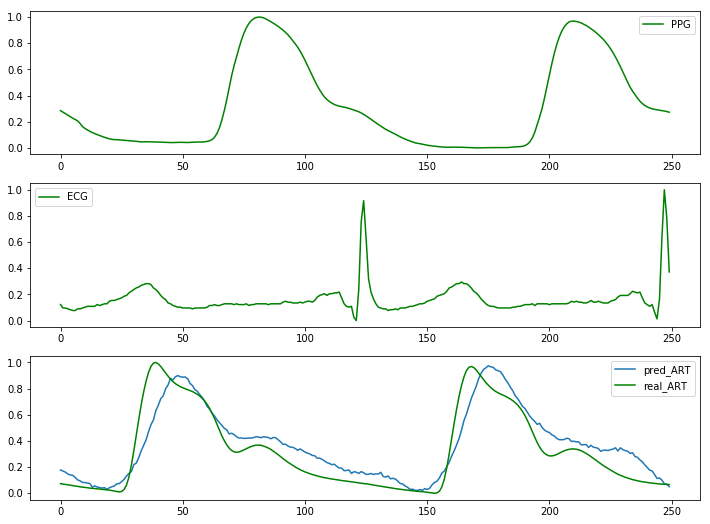

In [49]:
ix=10
print(np.expand_dims(np.hstack((testX_0_n[ix,:],testX_1_n[ix,:])).reshape(1,-1), axis=2).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
ax.legend()

#Predicted vs real
ax = plt.subplot(3,1,3)
ax.plot(model.predict(np.hstack((testX_0_n[ix,:],testX_1_n[ix,:])).reshape(1,-1)).T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

plt.show()